In [1]:
%matplotlib inline

from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sns

In [2]:
all_files = [fname for fname in os.listdir('data') if fname[-4:] == "json"]

In [3]:
# load all events
events = []
for i, fname in enumerate(all_files[:20]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        events.append(json.loads(line))

0 out of 504 files loaded
10 out of 504 files loaded


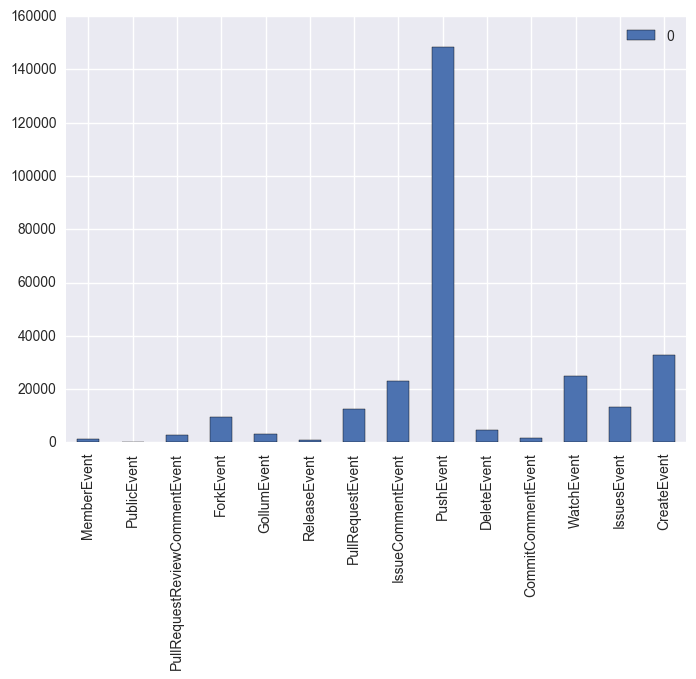

In [4]:
types = [e['type'] for e in events]
type_counts = Counter(types)
df = pd.DataFrame.from_dict(type_counts, orient='index')
df.plot(kind='bar')
plt.show()

In [5]:
actors = [e['actor']['login'] for e in events]
actor_count = Counter(actors)
over5 = np.sum([1 if v >=5 else 0 for v in actor_count.values()])
count_count = Counter(actor_count.values())

280186 75155 15582


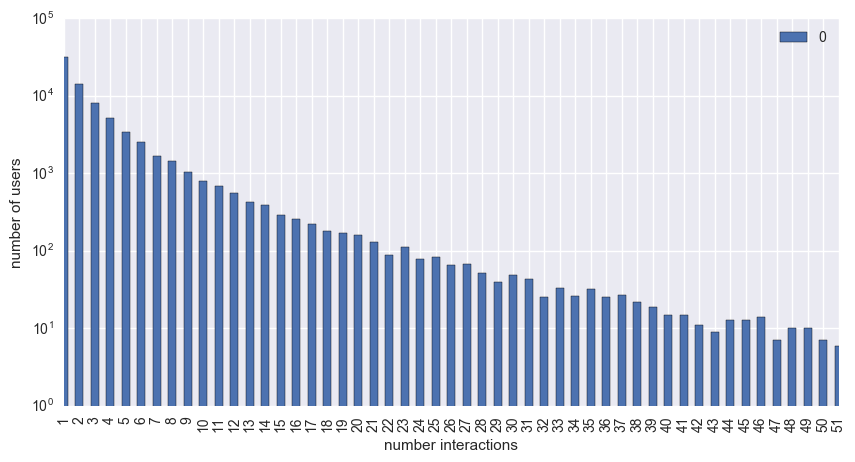

In [6]:
print len(actors), len(set(actors)), over5
df = pd.DataFrame.from_dict(count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number interactions")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Calculate common keys between all events

In [7]:
common_set = set(events[0].keys())
for i in range(1000):
    common_set = common_set & set(events[i].keys())
common_set

{u'actor', u'created_at', u'id', u'payload', u'public', u'repo', u'type'}

## Look into number of repos

In [8]:
repos = [e['repo']['name'] for e in events]
repo_count = Counter(repos)
df = pd.DataFrame.from_dict(repo_count, orient='index')
over5repos = np.sum([1 if v >=5 else 0 for v in repo_count.values()])
print len(repos), len(set(repos)), over5repos


280186 83777 13934


In [9]:
print len(df[df[0]>100]), "with over 100 commits in the files"
df[df[0]>100].sort_values(0, ascending=False).head(15)

71 with over 100 commits in the files


,0
KenanSulayman/heartbeat,1563
sakai-mirror/melete,600
qdm/qdm.github.io,581
dspinellis/unix-history-repo,501
rust-lang/rust,419
rdpeng/ExData_Plotting1,373
jtleek/datasharing,323
prakhar1989/awesome-courses,314
BLooperZ/blooperz.github.io,274
greatfire/wiki,250


## Repos per person

In [10]:
actor_repo = {a:set() for a in actors}

In [11]:
for e in events: 
    actor_repo[e['actor']['login']].add(e['repo']['name'])


In [12]:
a_r_count = {a:len(actor_repo[a]) for a in actors}

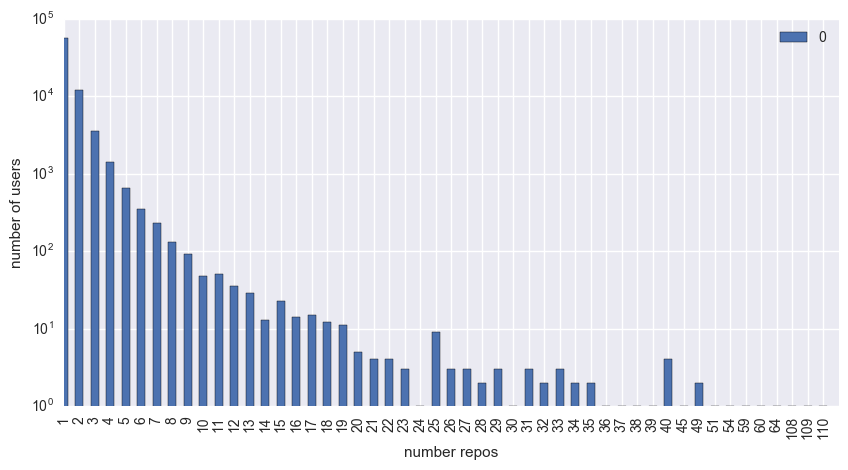

In [13]:
a_r_count_count = Counter(a_r_count.values())
df = pd.DataFrame.from_dict(a_r_count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number repos")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Get statistics over all data

In [21]:
# load all events
# events = []
repo_commits = Counter()
repo_users = Counter()
repo_users_names = Counter()

for i, fname in enumerate(all_files[:10]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        if e['type'] == 'PushEvent':
            num_comms = events[0]['payload']['distinct_size']
            repo_name = e['repo']['name']
            actor_name = e['actor']['login']
            repo_commits[repo_name] += num_comms
            if repo_users_names[repo_name]:
                repo_users_names[repo_name].add(actor_name)
            else:
                repo_users_names[repo_name] = set([actor_name])
            repo_users[repo_name] = len(repo_users_names[repo_name])
            
            #print num_comms, events[0]['payload']            
        

0 out of 504 files loaded


In [24]:
repo_users_names

Counter({u'nbjayme/Verbum': {u'nbjayme'},
         u'evilC/UCR': {u'evilC'},
         u'mozilla/sugardough': {u'glogiotatidis'},
         u'bohni/maxdocs': {u'bohni'},
         u'myfossil/WordPress': {u'woodb'},
         u'STEllAR-GROUP/hpx': {u'K-ballo', u'StellarBot'},
         u'Valtis/Lexer': {u'Valtis'},
         u'upndwn4par/proprietary_vendor_lge': {u'upndwn4par'},
         u'iooner/iooner.me': {u'iooner'},
         u'RobCranfill/ccam': {u'RobCranfill'},
         u'rohkal/GitHibTutHandsOn': {u'rohkal'},
         u'LinDA-tools/RDF2Any': {u'judie90'},
         u'freeformsystems/jsr-constants': {u'freeformsystems'},
         u'github-nix/AppsGit': {u'github-nix'},
         u'flicken/scalatest': {u'flicken'},
         u'swswsw/bmwwatchalert': {u'swswsw'},
         u'vlasenkoandrey/site': {u'vlasenkoandrey'},
         u'bvssvni/opengl_graphics': {u'bvssvni'},
         u'andystu/andystu.github.io': {u'andystu'},
         u'MShaheer/FixturesWebRepo': {u'MShaheer', u'ibntariq'},
       

In [22]:
def write(outfile, dictfile):
    out = open(outfile, "w")
    items = [(v, k) for k, v in dictfile.iteritems()]
    items.sort()
    for v, k in items:
        print >> out, k, v
    out.close()

In [23]:
write("repo_commits.txt", repo_commits)
write("repo_users.txt", repo_users)
write("repo_users_names.txt", repo_users_names)


In [19]:
repo_commits

Counter({u'maoueh/chefspec': 3,
         u'azanegin/systemd2rc': 1,
         u'willQ/pinteresting': 1,
         u'DANA-Laboratory/ThermophysicalCalculation.jl': 5,
         u'dotink/inkwell-view': 9,
         u'sasschreiber/THM.Products': 10,
         u'gpr321/test': 1,
         u'BrokenOs/android_build': 9,
         u'dar7yl/datasciencecoursera': 3,
         u'gurieveugen/ABBEY': 2,
         u'swswsw/bmwwatchalert': 1,
         u'k2015a2016/policy': 1,
         u'barchart/barchart-store': 1,
         u'srmo642002/Eshop': 13,
         u'aman-thakral/scipy': 3,
         u'lixm/ems': 3,
         u'rockdocta/GitFundamentals': 1,
         u'universeroc/universeroc.github.io': 3,
         u'umdbzj/test': 2,
         u'Yedion/iWallUserApp': 13,
         u'teamsnap/apn_on_rails': 3,
         u'odoo-latam/odoo-infrastructure': 5,
         u'jgcasta/FTPBusinessEvents': 8,
         u'shahuwang/images': 3,
         u'maur1th/naxos-project': 85,
         u'elasticsearch/demo': 3,
         u'fabioz

In [25]:
sorted(repo_users.iteritems(), key=operator.itemgetter(1), reverse=True)[:50]

[(u'mozilla-b2g/gaia', 85),
 (u'odoo-dev/odoo', 84),
 (u'SoftUni/test', 78),
 (u'edx/edx-platform', 69),
 (u'scottgs/swe-spring-2015', 59),
 (u'mks65-dw/final', 58),
 (u'whqiuyuan/INFSCI2711', 48),
 (u'Wikia/app', 46),
 (u'NixOS/nixpkgs', 46),
 (u'cs480-projects/cs480-projects.github.io', 45),
 (u'thebravoman/software_engineering_2014', 45),
 (u'aosp-exchange-group/fuck-2014-flirt-2015', 40),
 (u'hpi-swt2/event-und-raumplanung', 40),
 (u'guardian/frontend', 39),
 (u'domokit/mojo', 36),
 (u'mongodb/mongo', 36),
 (u'mamedev/mame', 34),
 (u'JuliaLang/julia', 34),
 (u'rahulkavale/wcebootcamp', 34),
 (u'BiomedEKG/ecg_holter', 33),
 (u'mantidproject/mantid', 32),
 (u'odoo/odoo', 32),
 (u'rails/rails', 32),
 (u'sagemath/grant-europe', 32),
 (u'danvallejo/2015-Winter-IT-FDN-105', 32),
 (u'neoskop/Parsley.js', 32),
 (u'fraxito/CodingBatArrays2', 31),
 (u'RHITJuniorProjects/JrProj-1415-Mike', 31),
 (u'elasticsearch/elasticsearch', 31),
 (u'pentaho/pentaho-kettle', 30),
 (u'dava/dava.framework', 

In [22]:
import operator